In [1]:
import sys
sys.path.append('..')

In [2]:
import re
from collections import defaultdict
from pathlib import Path
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans

from myutils.json import load_json, save_json
from myutils.colors import COLOR_NAMES

from src.pca import IPCA
from src.rzd import PlacePriceModel

%config InlineBackend.figure_formats = ['svg']

In [3]:
data_dir = Path('../data/2021_05_19/')
fname_re = re.compile('([^-]+)-([^-]+)-(price|place).csv')

places = pd.DataFrame()
prices = pd.DataFrame()

for fpath in data_dir.iterdir():
    if fpath.name.startswith('.'):
        continue
    
    df = pd.read_csv(fpath, encoding='cp1251', sep=';', index_col=0).T
    df.index = pd.to_datetime(df.index)
    df.columns.name = None
    
    num, cl, kind = fname_re.fullmatch(fpath.name).groups()
    
    if kind == 'place':
        df = df / df.max().max()
        
    else:  # prices
        df = df.replace(0, np.nan)
    
    df['num'] = num
    df['class'] = cl
    df = df.reset_index().rename(columns={'index': 'date'})
    
    if kind == 'place':
        places = places.append(df, ignore_index=True)
    
    else:  # prices
        prices = prices.append(df, ignore_index=True)
        
places = places.sort_values(by=['num', 'class', 'date']).set_index(['num', 'class', 'date'])
prices = prices.sort_values(by=['num', 'class', 'date']).set_index(['num', 'class', 'date'])

places.head()

1         2         3         4         5   \
num  class date                                                           
002А Купе  2021-04-03  0.381295  0.467626  0.474820  0.474820  0.568345   
           2021-04-04  0.287770  0.366906  0.431655  0.489209  0.561151   
           2021-04-05  0.625899  0.625899  0.647482  0.726619  0.798561   
           2021-04-06  0.726619  0.791367  0.834532  0.884892  0.935252   
           2021-04-07  0.618705  0.705036  0.705036  0.719424  0.748201   

                             6         7         8         9         10  
num  class date                                                          
002А Купе  2021-04-03  0.546763  0.546763  0.611511  0.661871  0.676259  
           2021-04-04  0.690647  0.690647  0.762590  0.762590  0.791367  
           2021-04-05  0.798561  0.812950  0.812950  0.812950  0.820144  
           2021-04-06  0.935252  0.935252  0.971223  0.971223  0.985612  
           2021-04-07  0.769784  0.784173  0.784173  0.791367  0.798561

## EDA & Preprocessing

In [4]:
display_trains = ['002А', '752А', '754А', '774А']

In [5]:
train_classes = places.reset_index().groupby('num')['class'].apply(lambda series: series.unique()).apply(sorted)

train_classes = train_classes.loc[display_trains]

n_trains = len(train_classes)
n_classes = train_classes.apply(len).max()

fig, axes = plt.subplots(nrows=n_trains, ncols=n_classes)
fig.set_size_inches(3.5 * n_classes, 2.5 * n_trains)
fig.subplots_adjust(hspace=0.55, wspace=0.2)

for i, train in enumerate(train_classes.index):
    classes = train_classes[train]

    for j in range(n_classes):
        ax = axes[i, j]

        if j < len(classes):
            class_ = classes[j]

            mask = (places.index.get_level_values(0) == train)\
                & (places.index.get_level_values(1) == class_)

            df = places[mask].droplevel([0, 1])
        
            df[[3, 6, 10]].plot(ax=ax, legend=False)

            ax.fill_betweenx([df.min().min(), df.max().max()], 18747, 18758, color='C0', alpha=0.1, label='holidays')

            ax.set_title(f'{train}, {class_}', fontsize=9)
            ax.set_xlabel('date')
            ax.tick_params(axis='x', which='major', labelbottom=False)
        
        else:
            ax.axis('off')
    
axes[0, 1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    
#     if i % 3 == 0:
#         axes[i, len(classes) - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Places vs. time', y=0.92)
        
plt.savefig('../data/figures/1_places_vs_time.svg', transparent=False, bbox_inches='tight')
plt.close()

In [6]:
trains_to_remove = ['757H', '762А', '764А', '766А']

places = places[~places.index.get_level_values(0).isin(trains_to_remove)]
prices = prices[~prices.index.get_level_values(0).isin(trains_to_remove)]

assert (places.index == prices.index).all()

In [7]:
train_classes = places.reset_index().groupby('num')['class'].apply(lambda series: series.unique()).apply(sorted)

train_classes = train_classes.loc[display_trains]

n_trains = len(train_classes)
n_classes = train_classes.apply(len).max()

fig, axes = plt.subplots(nrows=n_trains, ncols=n_classes)
fig.set_size_inches(3.5 * n_classes, 2.5 * n_trains)
fig.subplots_adjust(hspace=0.55, wspace=0.25)

for i, train in enumerate(train_classes.index):
    classes = train_classes[train]

    for j in range(n_classes):
        ax = axes[i, j]

        if j < len(classes):
            class_ = classes[j]
        
            mask = (prices.index.get_level_values(0) == train)\
                & (prices.index.get_level_values(1) == class_)

            df = prices[mask].droplevel([0, 1])
            df[[3, 6, 10]].plot(ax=ax, legend=False)

            ax.fill_betweenx([df.min().min(), df.max().max()], 18747, 18758, color='C0', alpha=0.1, label='holidays')

            ax.set_title(f'{train}, {class_}', fontsize=9)
            ax.set_xlabel('date')
            ax.tick_params(axis='x', which='major', labelbottom=False)
        
        else:
            ax.axis('off')

axes[0, 1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    
#     if i % 3 == 0:
#         axes[i, len(classes) - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Prices vs. time', y=0.92)
        
plt.savefig('../data/figures/2_prices_vs_time.svg', transparent=False, bbox_inches='tight')
plt.close()

In [8]:
holiday_mask = (places.index.get_level_values(2) >= datetime(year=2021, month=4, day=29)) \
    & (places.index.get_level_values(2) <= datetime(year=2021, month=5, day=12))

places = places[~holiday_mask]
prices = prices[~holiday_mask]

In [9]:
weekdays = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
            3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

In [10]:
train_classes = places.reset_index().groupby('num')['class'].apply(lambda series: series.unique()).apply(sorted)

train_classes = train_classes.loc[display_trains]

n_trains = len(train_classes)
n_classes = train_classes.apply(len).max()

fig, axes = plt.subplots(nrows=n_trains, ncols=n_classes)
fig.set_size_inches(3.5 * n_classes, 2.5 * n_trains)
fig.subplots_adjust(hspace=0.55, wspace=0.2)

for i, train in enumerate(train_classes.index):
    classes = train_classes[train]

    for j in range(n_classes):
        ax = axes[i, j]

        if j < len(classes):
            class_ = classes[j]
        
            mask = (places.index.get_level_values(0) == train)\
                & (places.index.get_level_values(1) == class_)

            df = places[mask].droplevel([0, 1])
            grp = df.groupby(lambda k: k.weekday())
            means = grp.mean().T.rename(columns=weekdays)
            stds = grp.std().T.rename(columns=weekdays)

            for k, col in enumerate(means.columns):
                ax.plot(means[col], label=col, c=f'C{k}')

                ox = means[col].index.values.astype(int)
                oy1 = (means[col] - stds[col]).values
                oy2 = (means[col] + stds[col]).values
                ax.fill_between(ox, oy1, oy2, alpha=0.1, color=f'C{k}')

            ax.set_title(f'{train}, {class_}', fontsize=9)
            ax.set_xlabel('days until departure')
            
        else:
            ax.axis('off')

axes[0, 1].legend(loc='lower left', bbox_to_anchor=(1, 0))

#     if i % 3 == 0:
#         axes[i, len(classes) - 1].legend(loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Places vs. days until departure', y=0.92)
        
plt.savefig('../data/figures/3_places_vs_days.svg', transparent=False, bbox_inches='tight')
plt.close()

In [11]:
weekends = load_json('../data/weekends.json')

for train in weekends:
    for class_, weekend in weekends[train].items():
        mask = (places.index.get_level_values(0) == train) \
            & (places.index.get_level_values(1) == class_) \
            & (places.index.get_level_values(2).weekday.isin(weekend))
        places = places[~mask]
        prices = prices[~mask]
        
        assert (places.index == prices.index).all()

## Model

In [12]:
train_classes = places.reset_index().groupby('num')['class'].apply(lambda series: series.unique()).apply(sorted)

models = {}
metrics = []

for train, classes in train_classes.iteritems():
    for class_ in classes:
        mask = (places.index.get_level_values(0) == train)\
            & (places.index.get_level_values(1) == class_)
        
        places_ = places[mask].droplevel([0, 1])
        prices_ = prices[mask].droplevel([0, 1])
        
        model = PlacePriceModel().fit(places_, prices_)
        models[(train, class_)] = model
        metrics.append((train, class_, model.explained_variance, model.r2))
        
metrics = pd.DataFrame(metrics, columns=['train', 'class', 'explained', 'r2'])

In [13]:
def truncate_values(df: pd.DataFrame, th: float) -> pd.DataFrame:
    values = df.values.copy()
    values[values < th] = np.nan
    df = pd.DataFrame(values, index=df.index, columns=df.columns)
    
    return df

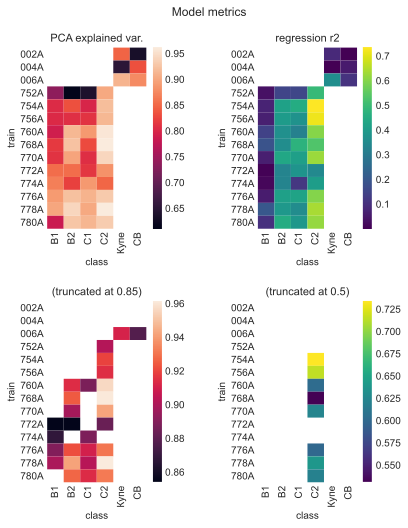

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(6, 8)
fig.subplots_adjust(wspace=0.7, hspace=0.4)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='train', columns='class', values='explained')
r2 = metrics.pivot(index='train', columns='class', values='r2')

sns.heatmap(explained, ax=ax1)
ax1.set_title('PCA explained var.', fontsize=11)

sns.heatmap(r2, ax=ax2, cmap='viridis')
ax2.set_title('regression r2', fontsize=11)

explained = truncate_values(explained, th=0.85)
r2 = truncate_values(r2, th=0.5)

sns.heatmap(explained, ax=ax3)
ax3.set_title('(truncated at 0.85)', fontsize=11)

sns.heatmap(r2, ax=ax4, cmap='viridis')
ax4.set_title('(truncated at 0.5)', fontsize=11)

fig.suptitle('Model metrics', y=0.95)

plt.savefig('../data/figures/4_model_metrics.svg', transparent=False, bbox_inches='tight')

In [15]:
train_classes = places.reset_index().groupby('num')['class'].apply(lambda series: series.unique()).apply(sorted)

train_classes = train_classes.loc[display_trains]

n_trains = len(train_classes)
n_classes = train_classes.apply(len).max()

fig, axes = plt.subplots(nrows=n_trains, ncols=n_classes)
fig.set_size_inches(3.5 * n_classes, 2.5 * n_trains)
fig.subplots_adjust(hspace=0.55, wspace=0.3)

handles = []
labels = []

for i, train in enumerate(train_classes.index):
    classes = train_classes[train]
    
    for j in range(n_classes):
        ax = axes[i, j]

        if j < len(classes):
            class_ = classes[j]
            model = models[(train, class_)]

            for k, dt in enumerate(model.index):
                weekday_id = dt.weekday()
                weekday = dt.strftime('%A')

                ax.scatter(model.places[k], model.prices[k], color=f'C{weekday_id}', label=weekday)

            ox = np.array([np.nanmin(model.places), np.nanmax(model.places)])
            ax.plot(ox, model.regression.b0 + model.regression.b1 * ox, c='black', ls='dashed', marker='None', zorder=5)

            ax.set_xlabel('places')
            ax.set_ylabel('price')
            ax.set_title(f'{train}, {class_}', fontsize=9)

            handles_, labels_ = ax.get_legend_handles_labels()
            handles.extend(handles_)
            labels.extend(labels_)
            
        else:
            ax.axis('off')
        
legend = dict(zip(labels, handles))
labels = list(weekdays.values())
handles = [legend[label] for label in labels]

axes[0, 1].legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

#     if i % 3 == 0:
#         legend = dict(zip(labels, handles))
#         labels = list(weekdays.values())
#         handles = [legend[label] for label in labels]
        
#         axes[i, len(classes) - 1].legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Price vs. places vs. date', y=0.92)
        
plt.savefig('../data/figures/5_price_vs_places_vs_date.svg', transparent=False, bbox_inches='tight')
plt.close()

In [16]:
train_classes = places.reset_index().groupby('num')['class'].apply(lambda series: series.unique()).apply(sorted)

train_classes = train_classes.loc[display_trains]

n_trains = len(train_classes)
n_classes = train_classes.apply(len).max()

fig, axes = plt.subplots(nrows=n_trains, ncols=n_classes)
fig.set_size_inches(3.5 * n_classes, 2.5 * n_trains)
fig.subplots_adjust(hspace=0.55, wspace=0.3)

cols = ['3', '6', '10']

handles = []
labels = []

for i, train in enumerate(train_classes.index):
    classes = train_classes[train]
    

    for j in range(n_classes):
        ax = axes[i, j]

        if j < len(classes):
            class_ = classes[j]
            model = models[(train, class_)]

            for k, col in enumerate(cols):
                ax.scatter(model.places[:, k], model.prices[:, k], color=f'C{k}', label=col)

            ox = np.array([np.nanmin(model.places), np.nanmax(model.places)])
            ax.plot(ox, model.regression.b0 + model.regression.b1 * ox, c='black', ls='dashed', marker='None', zorder=5)

            ax.set_xlabel('places')
            ax.set_ylabel('price')
            ax.set_title(f'{train}, {class_}', fontsize=9)

            handles_, labels_ = ax.get_legend_handles_labels()
            handles.extend(handles_)
            labels.extend(labels_)
            
        else:
            ax.axis('off')
        
legend = dict(zip(labels, handles))
labels = cols
handles = [legend[label] for label in labels]

axes[0, 1].legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))

#     if i % 3 == 0:
#         legend = dict(zip(labels, handles))
#         labels = cols
#         handles = [legend[label] for label in labels]
        
#         axes[i, len(classes) - 1].legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1))
        
plt.suptitle('Price vs. places vs. days until departure', y=0.92)
        
plt.savefig('../data/figures/6_price_vs_places_vs_days.svg', transparent=False, bbox_inches='tight')
plt.close()

In [42]:
train_classes = places.reset_index().groupby('num')['class'].apply(lambda series: series.unique()).apply(sorted)

a = {}
mean = {}
v = {}

for train, classes in train_classes.iteritems():
    for class_ in classes:
        key = f'{train}-{class_}'
        model = models[(train, class_)]
        
        if model.explained_variance >= 0.85:
            a[key] = model.a
            mean[key] = model.mean
            v[key] = model.v

a = pd.DataFrame(a)
v = pd.DataFrame(v).T
mean = pd.DataFrame(mean).T

a.reset_index().to_csv('../data/principal_components.csv', encoding='utf-8')

In [18]:
colors = dict(zip(train_classes.index, COLOR_NAMES))
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

In [20]:
plt.figure(figsize=(6, 6))

for train, classes in train_classes.iteritems():
    for i, class_ in enumerate(classes):
        c = colors[train]
        ls = linestyles[i]
        model = models[(train, class_)]
        
        if model.explained_variance < 0.85:
            continue
        
        plt.plot(model.mean, c=c, ls=ls, label=f'{train}, {class_}')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)

plt.title('mu(tau)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/7_pca_mu.svg', transparent=False, bbox_inches='tight')
plt.close()

In [19]:
plt.figure(figsize=(6, 6))

for train, classes in train_classes.iteritems():
    for i, class_ in enumerate(classes):
        c = colors[train]
        ls = linestyles[i]
        model = models[(train, class_)]
        
        if model.explained_variance < 0.85:
            continue
        
        plt.plot(model.v, c=c, ls=ls, label=f'{train}, {class_}')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)

plt.title('V(tau)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/8_pca_v.svg', transparent=False, bbox_inches='tight')
plt.close()

## Clustering: $V(\tau)$

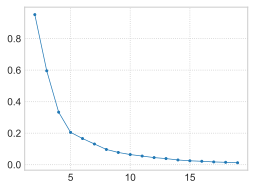

In [21]:
inertia = pd.Series({k: KMeans(k).fit(v.values).inertia_ for k in range(2, 20)})
inertia.plot();

In [22]:
k = 5
kmeans = KMeans(n_clusters=k).fit(v.values)
clusters = kmeans.predict(v.values)

fig, axes = plt.subplots(nrows=2, ncols=3)
axes = axes.flatten()
axes[-1].axis('off')
fig.set_size_inches(13, 6)
fig.subplots_adjust(hspace=0.35, wspace=0.75)

for i, ax in enumerate(axes[:-1]):
    vi = v.loc[clusters == i]
    
    vi.T.plot(ax=ax)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xlabel('days until departure')
    
fig.suptitle('V(tau) clusters', fontsize=13, y=0.95)

plt.savefig('../data/figures/9_pca_v_clusters.svg', transparent=False, bbox_inches='tight')
plt.close()

In [23]:
cluster_trains = {}

for i in np.unique(clusters):
    trains = v.loc[clusters == i].index.map(lambda s: tuple(s.split('-'))).tolist()
    explained = metrics.set_index(['train', 'class']).loc[trains, 'explained']
    idx = explained.argmax()
    train = explained.index[idx]
    cluster_trains[i] = train
    
cluster_trains = pd.Series(cluster_trains)
cluster_trains

0    (778А, C2)
1    (768А, C2)
2    (760А, C2)
3    (774А, C1)
4    (776А, C2)
dtype: object

In [39]:
dates = places.index.get_level_values(2).unique()[:15]

cm = LinearSegmentedColormap.from_list('cm', ['C0', 'C2', 'C3'])
colors = cm(np.linspace(0, 1, len(dates)))

dates

DatetimeIndex(['2021-04-03', '2021-04-04', '2021-04-05', '2021-04-06',
               '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10',
               '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14',
               '2021-04-15', '2021-04-16', '2021-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

In [40]:
fig, axes = plt.subplots(nrows=len(cluster_trains), ncols=4)
fig.set_size_inches(13, 2.5 * len(cluster_trains))
fig.subplots_adjust(hspace=0.65, wspace=0.35)

linestyles = ['dashed', 'dotted']

for i, (train, class_) in cluster_trains.iteritems():
    model = models[(train, class_)]
    
    ax = axes[i, 0]
    ser = model.a[dates].copy()
    ax.plot(ser, c='C0', label='a(t)')
    ax.set_xticks(ser.index)
    ax.set_xticklabels(ser.index.day_name().str.slice(0, 3), rotation=90)
    ax.set_title(f'{train}, {class_}, a(t)', fontsize=9)
    
    ax = axes[i, 1]
    model.v.plot(ax=ax, c='C1', label='V(tau)')
    ax.set_xticks(model.v.index)
    ax.set_xticklabels(model.v.index)
    ax.set_title(f'{train}, {class_}, V(tau)', fontsize=9)
    ax.set_xlabel('days until departure')
    
    ax = axes[i, 2]
    shift = np.abs([model.a[dates].min(), model.a[dates].max()]).mean()
    shift = np.linspace(0, shift, 3)[1:].round(1)
    

    model.mean.plot(ax=ax, c='C2', label='mu')
    
    for j, s in enumerate(shift):
        (model.mean + s * model.v).plot(ax=ax, c=f'C2', ls=linestyles[j], label=f'+- {s} * V')
        ax.plot(model.mean - s * model.v, c='C2', ls=linestyles[j])
            
    ax.set_title(f'{train}, {class_}, mu(tau)', fontsize=9)
    ax.set_xlabel('days until departure')
    ax.set_xticks(model.mean.index)
    ax.set_xticklabels(model.mean.index)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.55), ncol=3)
    
    ax = axes[i, 3]
    places_ = places.loc[(train, class_)].reindex(dates)
    places_.index = places_.index.day_name().str.slice(0, 3)
    
    for j, c in enumerate(colors):
        row = places_.iloc[j]
        row.plot(ax=ax, c=c)
    
    ax.set_title(f'{train}, {class_}, places')
    ax.set_xticks(model.columns)
    ax.set_xticklabels(model.columns)
    ax.set_xlabel('days until departure')

    if i % 2 == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.suptitle('PCA cluster models', fontsize=13, y=0.92)
plt.savefig('../data/figures/10_pca_v_cluster_models.svg', transparent=False, bbox_inches='tight')
plt.close()

In [38]:
columns = [item[1] for item in sorted(zip(clusters, a.columns))]

plt.figure(figsize=(8, 6))
sns.heatmap(a[columns].corr(method='spearman'), vmin=-1, vmax=1, square=True, cmap='coolwarm')
plt.title('Correlations between A(t)', fontsize=13)

ax = plt.gca()

i = 0

for n in pd.Series(clusters).value_counts().sort_index():
    rect = Rectangle((i, i), n, n, facecolor='None', linewidth=1, edgecolor='black', label='V(tau) clusters' if i == 0 else None)
    ax.add_patch(rect)
    i += n

plt.legend(loc='lower left')
    
plt.savefig('../data/figures/11_pca_a_correlations.svg', transparent=False, bbox_inches='tight')
plt.close()